## Temperature Contour Fill, Geopotential Height Contour Lines, and Wind Barbs
### For this notebook, we will be forecasting the Temperature and Geopotential Height through XWRF utilizing our WRF output for the December 2008 Ice Storm

Our imports

In [3]:
import xwrf
import metpy.calc as mpcalc
from metpy.calc import wind_speed
from metpy.units import units
from metpy.plots import SkewT
import xgcm
import numpy as np
from pyproj import Transformer, CRS
import pint_xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
from datetime import datetime, timedelta

Opening our WRF output file for the December 11th, 2008 Ice Storm. As well as dropping our variable for Dobson Units, to avoid Metpy units-parsing error

In [4]:
ds=xr.open_dataset('/ktyle_rit/mp856533/atm498/icestorm/exp1/wrfout_d01_2008-12-11_00:00:00', chunks='auto').xwrf.postprocess()
ds = ds.drop_vars('O3_GFS_DU') # Avoids MetPy units-parsing error with Dobson units
ds

<xarray.Dataset> Size: 645MB
Dimensions:                    (Time: 49, y: 49, x: 49, soil_layers_stag: 4,
                                z: 56, x_stag: 50, y_stag: 50, z_stag: 57,
                                num_stoch_levels: 57, seed_dim_stag: 2)
Coordinates: (12/15)
    XLAT                       (y, x) float32 10kB dask.array<chunksize=(49, 49), meta=np.ndarray>
    XLONG                      (y, x) float32 10kB dask.array<chunksize=(49, 49), meta=np.ndarray>
    XTIME                      (Time) datetime64[ns] 392B dask.array<chunksize=(49,), meta=np.ndarray>
    XLAT_U                     (y, x_stag) float32 10kB dask.array<chunksize=(49, 50), meta=np.ndarray>
    XLONG_U                    (y, x_stag) float32 10kB dask.array<chunksize=(49, 50), meta=np.ndarray>
    XLAT_V                     (y_stag, x) float32 10kB dask.array<chunksize=(50, 49), meta=np.ndarray>
    ...                         ...
  * z_stag                     (z_stag) float32 228B 1.0 0.9938 ... 0.003327 0.0
  * Time                       (Time) datetime64[ns] 392B 2008-12-11 ... 2008...
  * x                          (x) float64 392B -8.64e+05 -8.28e+05 ... 8.64e+05
  * y                          (y) float64 392B -8.64e+05 -8.28e+05 ... 8.64e+05
  * x_stag                     (x_stag) float64 400B -8.82e+05 ... 8.82e+05
  * y_stag                     (y_stag) float64 400B -8.82e+05 ... 8.82e+05
Dimensions without coordinates: soil_layers_stag, num_stoch_levels,
                                seed_dim_stag
Data variables: (12/195)
    Times                      (Time) |S19 931B dask.array<chunksize=(49,), meta=np.ndarray>
    LU_INDEX                   (Time, y, x) float32 471kB dask.array<chunksize=(38, 49, 49), meta=np.ndarray>
    ZS                         (Time, soil_layers_stag) float32 784B dask.array<chunksize=(49, 4), meta=np.ndarray>
    DZS                        (Time, soil_layers_stag) float32 784B dask.array<chunksize=(49, 4), meta=np.ndarray>
    VAR_SSO                    (Time, y, x) float32 471kB dask.array<chunksize=(38, 49, 49), meta=np.ndarray>
    BATHYMETRY_FLAG            (Time) int32 196B dask.array<chunksize=(49,), meta=np.ndarray>
    ...                         ...
    geopotential_height        (Time, z_stag, y, x) float32 27MB dask.array<chunksize=(5, 57, 49, 49), meta=np.ndarray>
    wind_east                  (Time, z, y, x) float32 26MB dask.array<chunksize=(5, 56, 49, 49), meta=np.ndarray>
    wind_north                 (Time, z, y, x) float32 26MB dask.array<chunksize=(5, 56, 49, 49), meta=np.ndarray>
    wind_east_10               (Time, y, x) float32 471kB dask.array<chunksize=(38, 49, 49), meta=np.ndarray>
    wind_north_10              (Time, y, x) float32 471kB dask.array<chunksize=(38, 49, 49), meta=np.ndarray>
    wrf_projection             object 8B +proj=lcc +x_0=0 +y_0=0 +a=6370000 +...
Attributes: (12/141)
    TITLE:                            OUTPUT FROM WRF V4.5.1 MODEL
    START_DATE:                      2008-12-11_00:00:00
    SIMULATION_START_DATE:           2008-12-11_00:00:00
    WEST-EAST_GRID_DIMENSION:        50
    SOUTH-NORTH_GRID_DIMENSION:      50
    BOTTOM-TOP_GRID_DIMENSION:       57
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

Creating our WRF projection and defining our Latitudes and Longitudes

In [5]:
wrf_proj = ds.wrf_projection
wrf_proj

<xarray.DataArray 'wrf_projection' ()> Size: 8B
array(<Projected CRS: +proj=lcc +x_0=0 +y_0=0 +a=6370000 +b=6370000 +lat ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich
, dtype=object)
Attributes: (12/16)
    crs_wkt:                        PROJCRS["unknown",BASEGEOGCRS["unknown",D...
    semi_major_axis:                6370000.0
    semi_minor_axis:                6370000.0
    inverse_flattening:             0.0
    reference_ellipsoid_name:       unknown
    longitude_of_prime_meridian:    0.0
    ...                             ...
    grid_mapping_name:              lambert_conformal_conic
    standard_parallel:              (40.0, 40.0)
    latitude_of_projection_origin:  40.000003814697266
    longitude_of_central_meridian:  -75.0
    false_easting:                  0.0
    false_northing:                 0.0

In [6]:
if (wrf_proj.grid_mapping_name == 'lambert_conformal_conic'):
    lat_1, lat_2 = wrf_proj.standard_parallel
    lat_0 = wrf_proj.latitude_of_projection_origin
    lon_0 = wrf_proj.longitude_of_central_meridian
    a = wrf_proj.semi_major_axis
    b = wrf_proj.semi_minor_axis
    proj_data= ccrs.LambertConformal(central_longitude=lon_0, central_latitude=lat_0,
                                standard_parallels=[lat_1,lat_2],
                                globe=ccrs.Globe(semimajor_axis=a, semiminor_axis=b))

Destaggering our variables for air potential temperature, geopotential height, and wind speed in order to obtain the correct variables for the plots we need to create

In [7]:
destaggered = ds.xwrf.destagger().metpy.quantify()
destaggered.air_potential_temperature

<xarray.DataArray 'air_potential_temperature' (Time: 49, z: 56, y: 49, x: 49)> Size: 26MB
<Quantity(dask.array<add, shape=(49, 56, 49, 49), dtype=float32, chunksize=(5, 56, 49, 49), chunktype=numpy.ndarray>, 'kelvin')>
Coordinates:
    XTIME    (Time) datetime64[ns] 392B dask.array<chunksize=(49,), meta=np.ndarray>
  * Time     (Time) datetime64[ns] 392B 2008-12-11 ... 2008-12-13
    XLAT     (y, x) float32 10kB dask.array<chunksize=(49, 49), meta=np.ndarray>
    XLONG    (y, x) float32 10kB dask.array<chunksize=(49, 49), meta=np.ndarray>
    CLAT     (y, x) float32 10kB dask.array<chunksize=(49, 49), meta=np.ndarray>
  * x        (x) float64 392B -8.64e+05 -8.28e+05 ... 8.28e+05 8.64e+05
  * y        (y) float64 392B -8.64e+05 -8.28e+05 ... 8.28e+05 8.64e+05
  * z        (z) float32 224B 0.9969 0.9899 0.981 ... 0.008745 0.005096 0.001663
Attributes:
    standard_name:  air_potential_temperature
    grid_mapping:   wrf_projection

In [8]:
destaggered['wind_speed']= wind_speed(destaggered.U, destaggered.V)
U=destaggered.U
V=destaggered.V
wind_speed

<function metpy.calc.wind_speed(u, v)>

In [9]:
destaggered.geopotential_height

<xarray.DataArray 'geopotential_height' (Time: 49, z: 56, y: 49, x: 49)> Size: 26MB
<Quantity(dask.array<mul, shape=(49, 56, 49, 49), dtype=float32, chunksize=(5, 56, 49, 49), chunktype=numpy.ndarray>, 'meter')>
Coordinates:
    XTIME    (Time) datetime64[ns] 392B dask.array<chunksize=(49,), meta=np.ndarray>
  * Time     (Time) datetime64[ns] 392B 2008-12-11 ... 2008-12-13
    XLAT     (y, x) float32 10kB dask.array<chunksize=(49, 49), meta=np.ndarray>
    XLONG    (y, x) float32 10kB dask.array<chunksize=(49, 49), meta=np.ndarray>
    CLAT     (y, x) float32 10kB dask.array<chunksize=(49, 49), meta=np.ndarray>
  * x        (x) float64 392B -8.64e+05 -8.28e+05 ... 8.28e+05 8.64e+05
  * y        (y) float64 392B -8.64e+05 -8.28e+05 ... 8.28e+05 8.64e+05
  * z        (z) float32 224B 0.9969 0.9899 0.981 ... 0.008745 0.005096 0.001663
Attributes:
    standard_name:  geopotential_height
    grid_mapping:   wrf_projection

Converting our air potential temperature into air temperature for our plot, then identifying the levels of the tmospher that we will be looking at

In [10]:
air_pressure = destaggered.air_pressure.pint.to('hPa').metpy.dequantify()
potential_temperature = destaggered.air_potential_temperature.pint.to('degC').metpy.dequantify()
air_temperature = mpcalc.temperature_from_potential_temperature(air_pressure, potential_temperature)
air_temperature = air_temperature.pint.to('degC').metpy.dequantify()
air_temperature

<xarray.DataArray 'mul-86ed691a2ada461ecbdd3c07fca10337' (Time: 49, z: 56,
                                                          y: 49, x: 49)> Size: 26MB
dask.array<truediv, shape=(49, 56, 49, 49), dtype=float32, chunksize=(5, 56, 49, 49), chunktype=numpy.ndarray>
Coordinates:
    XTIME    (Time) datetime64[ns] 392B dask.array<chunksize=(49,), meta=np.ndarray>
  * Time     (Time) datetime64[ns] 392B 2008-12-11 ... 2008-12-13
    XLAT     (y, x) float32 10kB dask.array<chunksize=(49, 49), meta=np.ndarray>
    XLONG    (y, x) float32 10kB dask.array<chunksize=(49, 49), meta=np.ndarray>
    CLAT     (y, x) float32 10kB dask.array<chunksize=(49, 49), meta=np.ndarray>
  * x        (x) float64 392B -8.64e+05 -8.28e+05 ... 8.28e+05 8.64e+05
  * y        (y) float64 392B -8.64e+05 -8.28e+05 ... 8.28e+05 8.64e+05
  * z        (z) float32 224B 0.9969 0.9899 0.981 ... 0.008745 0.005096 0.001663
Attributes:
    units:    degree_Celsius

In [11]:
target_levels = np.array([850,700,500,300])
grid = xgcm.Grid(destaggered, periodic=False)
Temp= grid.transform(air_temperature.metpy.dequantify(), 'Z', target_levels, target_data=air_pressure, method='log')
temp = Temp.compute()
geo= grid.transform(destaggered.geopotential_height.metpy.dequantify(), 'Z', target_levels, target_data=air_pressure, method='log')
Geo = geo.compute()
wspd = grid.transform(destaggered.wind_speed.metpy.dequantify(), 'Z', target_levels, target_data=air_pressure, method='log')
U_wind=grid.transform(destaggered.U.metpy.dequantify(), 'Z', target_levels, target_data=air_pressure, method='log')
V_wind=grid.transform(destaggered.V.metpy.dequantify(), 'Z', target_levels, target_data=air_pressure, method='log')
wspd = wspd.compute()
uwind=U_wind.compute()
vwind=V_wind.compute()

/knight/jan25/envs/jan25_env/lib/python3.12/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/knight/jan25/envs/jan25_env/lib/python3.12/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/knight/jan25/envs/jan25_env/lib/python3.12/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/knight/jan25/envs/jan25_env/lib/python3.12/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be r

In [12]:
Geo = Geo/10
Geo

<xarray.DataArray 'geopotential_height' (Time: 49, y: 49, x: 49, air_pressure: 4)> Size: 4MB
array([[[[149.9365161 , 310.92171916, 576.68737651, 949.92613134],
         [150.22906646, 311.26748771, 577.02846866, 950.12605614],
         [150.53182943, 311.63931476, 577.39621592, 950.31602567],
         ...,
         [160.99734838, 321.58715619, 587.66005323, 956.62329241],
         [161.11820385, 321.6650632 , 587.7291737 , 956.67051154],
         [161.24487634, 321.73490014, 587.74636516, 956.69396145]],

        [[149.71059019, 310.60927069, 576.32048812, 949.39998277],
         [149.9879698 , 310.93772915, 576.66522508, 949.62623446],
         [150.27679195, 311.29183889, 577.02906552, 949.8352889 ],
         ...,
         [161.01209433, 321.63786624, 587.60192389, 956.39434252],
         [161.16293134, 321.74803945, 587.70790805, 956.47659213],
         [161.30863904, 321.83385716, 587.74656159, 956.52005268]],

        [[149.51729278, 310.32745008, 576.02648202, 949.00817298],
         [149.7532164 , 310.60187111, 576.34059916, 949.22342676],
         [150.02404256, 310.91754479, 576.67537234, 949.42522836],
         ...,
...
         ...,
         [129.85066267, 287.67880116, 551.29373384, 920.68122032],
         [130.62041446, 288.75656245, 552.63814608, 922.32618663],
         [131.5151526 , 289.83056726, 553.89418972, 923.94344112]],

        [[136.48217284, 281.32345902, 524.40175848, 864.65508808],
         [136.61361877, 281.26243274, 524.33406305, 864.51141255],
         [136.77046641, 281.28871702, 524.29279226, 864.38944439],
         ...,
         [129.04589254, 286.80030836, 550.32687507, 919.62053082],
         [129.85400004, 287.90920782, 551.6827352 , 921.27238227],
         [130.94033265, 289.21145694, 553.16203188, 923.09750968]],

        [[136.01119383, 280.65162065, 523.52641853, 863.74625114],
         [135.98377242, 280.38937508, 523.19755478, 863.31082294],
         [136.2043638 , 280.49198127, 523.24643409, 863.22529242],
         ...,
         [128.50155731, 286.20067842, 549.67084661, 918.69465479],
         [129.29863332, 287.22395322, 550.88496562, 920.3440874 ],
         [130.35969047, 288.58060235, 552.40847119, 922.20857114]]]])
Coordinates:
    XTIME         (Time) datetime64[ns] 392B 2008-12-11 ... 2008-12-13
  * Time          (Time) datetime64[ns] 392B 2008-12-11 ... 2008-12-13
    XLAT          (y, x) float32 10kB 31.86 31.89 31.92 ... 47.33 47.29 47.25
    XLONG         (y, x) float32 10kB -84.08 -83.7 -83.32 ... -64.08 -63.61
    CLAT          (y, x) float32 10kB 31.86 31.89 31.92 ... 47.33 47.29 47.25
  * x             (x) float64 392B -8.64e+05 -8.28e+05 ... 8.28e+05 8.64e+05
  * y             (y) float64 392B -8.64e+05 -8.28e+05 ... 8.28e+05 8.64e+05
  * air_pressure  (air_pressure) int64 32B 850 700 500 300

Creating our time variable

In [13]:
times=np.array(ds.Time, dtype='datetime64')
Times=times.astype('datetime64[s]').tolist()

Plotting our data

FileNotFoundError: [Errno 2] No such file or directory: 'Temperature Geo Maps/0000 UTC 11 Dec 2008_850_Temp_Geo.png'

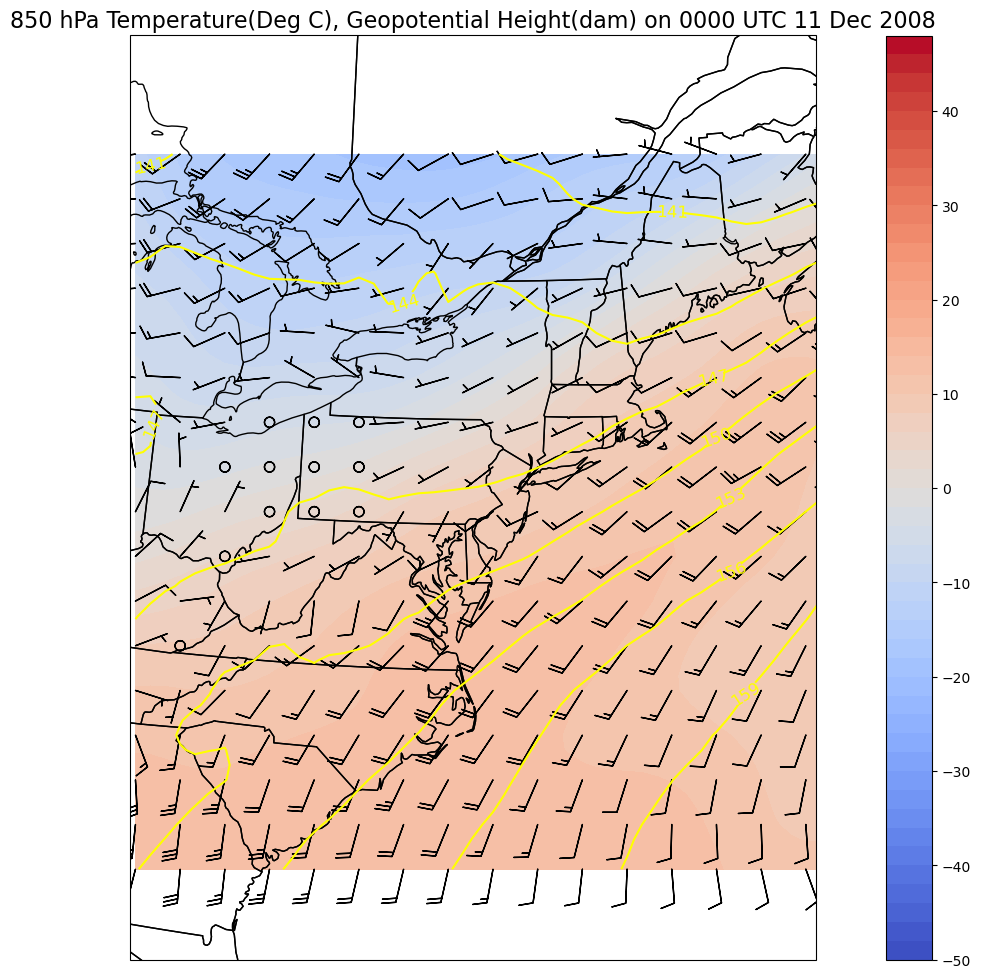

In [14]:
n=2
for j in range(0,n):
    for i in target_levels:
        if (i>=850):
            inc=3
        elif (i>=700):
            inc=3
        elif (i>=500):
            inc=6
        else:
            inc=9
        fint=np.arange(0,3000,inc)
        raobtitle=Times[j].strftime("%H00 UTC %-d %b %Y")
        tint=np.arange(-50,50,2)
        latN = 50
        latS = 30
        lonW = -84
        lonE = -67
        lon, lat = np.meshgrid(wspd.x.values, wspd.y.values)
        res = '50m'
        u_vals=uwind.isel(Time=12).sel(air_pressure=i).values
        v_vals=vwind.isel(Time=12).sel(air_pressure=i).values
        fig = plt.figure(figsize=(18,12))
        ax = fig.add_subplot(1,1,1,projection=proj_data)
        ax.set_extent ([lonW,lonE,latS,latN],crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE.with_scale(res))
        ax.add_feature(cfeature.STATES.with_scale(res))
#Add new title
        tl1=f'{i} hPa Temperature(Deg C), Geopotential Height(dam) on {raobtitle}'
        tl2=f'{raobtitle}_{i}_Temp_Geo'
        ax.set_title(f'{tl1}',fontsize=16)
        Cf = ax.contourf(temp.x,temp.y, temp.isel(Time=j).sel(air_pressure=i),levels=tint,cmap='coolwarm')
        C = ax.contour(Geo.x,Geo.y, Geo.isel(Time=j).sel(air_pressure=i),levels=fint,colors='#FFFF00')
        skip=3
        ax.barbs(lon[::skip,::skip], lat[::skip,::skip], u_vals[::skip,::skip],v_vals[::skip,::skip])
        ax.clabel(C, inline=1, fontsize=12)
        cbar=plt.colorbar(Cf)
        fig.savefig(f'Temperature Geo Maps/{tl2}.png')